# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now). The input files from which these flat ntuples are produced are MiniAOD samples from the Run3Winter22 campaign (`CMSSW_12_2_3_patch1`).

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```

These variables in the ntuple are produced using the following script.

**ntuple maker:** <a href="https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/test/testElectronMVA_cfg.py">GitHub: cmssw/RecoEgamma/ElectronIdentification/test
/testElectronMVA_cfg.py</a> 

#### The goal of this study is to compare these scores with the MVA scores.

### Reading the input files as dataframes:

In [1]:
import os, sys
import uproot
filedy = uproot.open('inputs/Run3Winter22/electron_ntuple_DYJetsToLL_M-50.root')
filett = uproot.open('inputs/Run3Winter22/electron_ntuple_TTToSemiLeptonic.root')
print('The input files are read using uproot.')

The input files are read using uproot.


In [2]:
import pandas as pd
import numpy as np

treedy = filedy['ntuplizer/tree']
treett = filett['ntuplizer/tree']

branches = [
    'matchedToGenEle', #flag for deciding whether it is a signal or background electron 
    'dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon', #DNN scores
    'Fall17IsoV2Vals', 'Fall17IsoV2RawVals' #MVA IDs from Run2
]

#Turning the branches into awkward arrays, then into dataframes:
awkarray1 = treedy.arrays(branches)
dfdy = pd.DataFrame(awkarray1.tolist())
dfdy['sample'] = 'dy'

awkarray2 = treett.arrays(branches)
dftt = pd.DataFrame(awkarray2.tolist())
dftt['sample'] = 'tt'

#The final dataframe containing everything:
df=pd.concat([dfdy, dftt])

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5',
    'matchedToGenEle':'genmatch',
    'Fall17IsoV2Vals':'MVA1',
    'Fall17IsoV2RawVals':'MVA2'
}

df.rename(columns = rename, inplace = True)

#Let's normalize the variables from 0 to 1
def normalize_col(df, col):
    if df[col].max() != df[col].min():
        df[col] = (df[col]-df[col].min()) / (df[col].max()-df[col].min())
    else:
        print('Scaling error: max and min are the same!')
    return df

#Only the MVA scores require normalization
df=normalize_col(df, 'MVA1')
df=normalize_col(df, 'MVA2')

df

,genmatch,score1,score2,score3,score4,score5,MVA1,MVA2,sample
0,1,0.863116,0.004818,0.000275,0.004286,0.127505,0.999712,0.683327,dy
1,1,0.989065,0.001232,0.000117,0.003947,0.005639,1.000000,0.825950,dy
2,2,0.825752,0.009598,0.004022,0.119532,0.041096,0.999997,0.772846,dy
3,1,0.842872,0.004903,0.003169,0.059217,0.089840,0.999889,0.701700,dy
4,1,0.990293,0.000186,0.000033,0.003566,0.005922,1.000000,0.908820,dy
...,...,...,...,...,...,...,...,...,...
57638,0,0.000379,0.118100,0.813809,0.048510,0.019203,0.000151,0.357256,tt
57639,1,0.991748,0.000376,0.000003,0.000247,0.007626,1.000000,0.939797,tt
57640,0,0.005026,0.117231,0.540902,0.314087,0.022754,0.000925,0.392166,tt
57641,1,0.013731,0.985943,0.000128,0.000075,0.000123,0.999741,0.685368,tt


### Defining signal and background electrons:

The variable, `matchedToGenEle` contains integers, which mean the following things:

- 0: The candidate does not match to any gen-electron. (fake)
- 1: The candidate is a prompt, real electron; matches to gen-electron.
- 2: The candidate is a prompt, gen-matched electron decaying from a tau (not part of a jet).
- 3: The candidate is a real electron, but not isolated.

The signal electrons have `matchedToGenEle == 1 OR 2`<br>
The backgrounds have `matchedToGenEle == 0 OR 3`

In [3]:
df.loc[(df['genmatch'] == 1) | (df['genmatch'] == 2), 'truth'] = 1 # signal
df.loc[(df['genmatch'] == 0) | (df['genmatch'] == 3), 'truth'] = 0 # background

#Randomizing rows:
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

#Printing out some results:
print(df[['genmatch', 'sample', 'truth']].head())

ndy     =df[df["sample"] =="dy"].shape[0]
ndy_sig =df[(df["sample"]=="dy")&(df["truth"]==1)].shape[0]
ndy_bkg =df[(df["sample"]=="dy")&(df["truth"]==0)].shape[0]

ntt     =df[df["sample"] =="tt"].shape[0]
ntt_sig =df[(df["sample"]=="tt")&(df["truth"]==1)].shape[0]
ntt_bkg =df[(df["sample"]=="tt")&(df["truth"]==0)].shape[0]

print(f'\nNo of electron candidates from ...')
print(f'Drell-Yan sample: {ndy}; sig = {ndy_sig} ({ndy_sig*100/ndy:.1f}%), bkg = {ndy_bkg} ({ndy_bkg*100/ndy:.1f}%)')
print(f'TTbar sample: {ntt}; sig = {ntt_sig} ({ntt_sig*100/ndy:.1f}%), bkg = {ntt_bkg} ({ntt_bkg*100/ntt:.1f}%)')

   genmatch sample  truth
0         0     tt    0.0
1         3     tt    0.0
2         3     tt    0.0
3         0     tt    0.0
4         0     dy    0.0

No of electron candidates from ...
Drell-Yan sample: 37303; sig = 29432 (78.9%), bkg = 7871 (21.1%)
TTbar sample: 57643; sig = 16353 (43.8%), bkg = 41290 (71.6%)


### Making some basic plots : DNN scores:

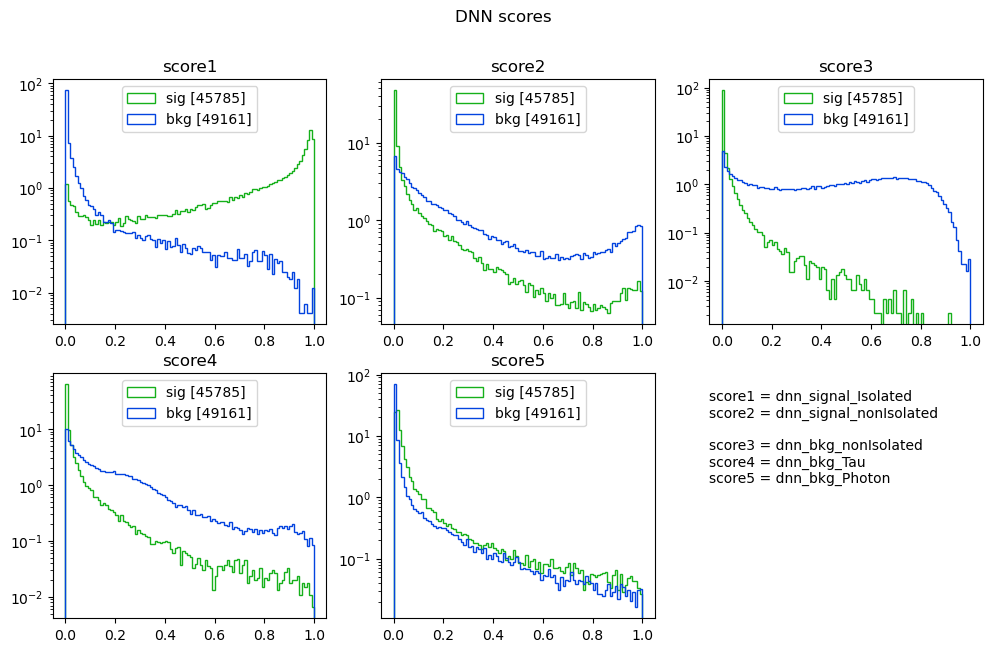

In [4]:
os.system('mkdir -p plots')

import matplotlib as mpl
import matplotlib.pyplot as plt

nsig=df[df['truth']==1].shape[0]
nbkg=df[df['truth']==0].shape[0]

fig1, ax1 = plt.subplots(2,3,figsize=(12,7))
ax1 = ax1.flatten()

# Add the score details as left-aligned text
text = '''
score1 = dnn_signal_Isolated
score2 = dnn_signal_nonIsolated

score3 = dnn_bkg_nonIsolated
score4 = dnn_bkg_Tau
score5 = dnn_bkg_Photon
'''

#fig1.subplots_adjust(hspace=0.5, wspace=0.1)
bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
fig1.suptitle('DNN scores') #Global title

vardnn = ['score1', 'score2', 'score3', 'score4', 'score5']

for i in range(len(vardnn)):
    ax1[i].hist(df[df['truth']==1][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax1[i].hist(df[df['truth']==0][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax1[i].set_title(vardnn[i])
    ax1[i].set_yscale('log')
    ax1[i].legend(loc='upper center')
    
ax1[-1].text(0, 1, text, transform=ax1[-1].transAxes, fontsize=10, ha='left', va='top')
ax1[-1].axis('off')

plt.show()

### Making some basic plots : MVA scores:

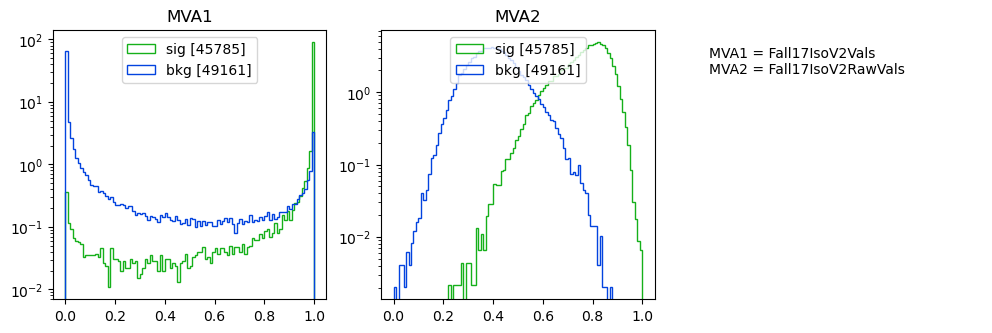

In [5]:
fig2, ax2 = plt.subplots(1,3,figsize=(12,3.5))
ax2 = ax2.flatten()

# Add the score details as left-aligned text
text = '''
MVA1 = Fall17IsoV2Vals
MVA2 = Fall17IsoV2RawVals
'''

#fig1.subplots_adjust(hspace=0.5, wspace=0.1)
bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
#fig2.suptitle('MVA scores') #Global title

varmva = ['MVA1','MVA2']

for i in range(len(varmva)):
    ax2[i].hist(df[df['truth']==1][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax2[i].hist(df[df['truth']==0][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax2[i].set_title(varmva[i])
    ax2[i].set_yscale('log')
    ax2[i].legend(loc='upper center')
    
ax2[-1].text(0, 1, text, transform=ax2[-1].transAxes, fontsize=10, ha='left', va='top')
ax2[-1].axis('off')

plt.show()

## ROC for the DNN scores and the MVA IDs

In [6]:
#ROC calculation:
from sklearn.metrics import roc_curve,auc

true = df['truth'] #Either 0, or 1
predDNN1 = df['score1'] #goes from 0 to 1
predDNN2 = df['score2'] #goes from 0 to 1
predDNNcomb = df['score1']+df['score2'] #goes from 0 to 1
predMVA1 = df['MVA1'] #goes from 0 to 1

def find_tpr_fnr_auc(df):
    fpr, tpr, _ = roc_curve(true, df)
    auc_score   = auc(tpr,1-fpr)
    tpr=tpr*100
    fnr=(1-fpr)*100
    return fnr, tpr, auc_score
    
fnr1, tpr1, auc1 = find_tpr_fnr_auc(predDNN1)
fnr2, tpr2, auc2 = find_tpr_fnr_auc(predDNN2)
fnr3, tpr3, auc3 = find_tpr_fnr_auc(predMVA1)
fnr4, tpr4, auc4 = find_tpr_fnr_auc(predDNNcomb)

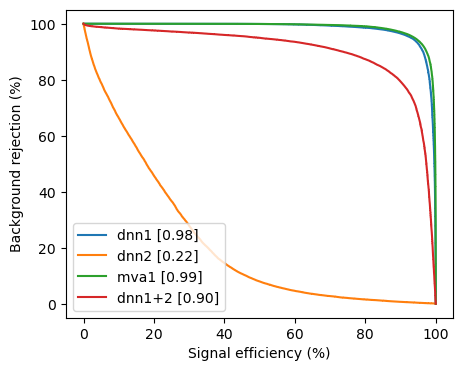

In [7]:
fig3, ax3 = plt.subplots(1,1,figsize=(5,4))

ax3.plot(tpr1,fnr1, label=f'dnn1 [{auc1:.2f}]')
ax3.plot(tpr2,fnr2, label=f'dnn2 [{auc2:.2f}]')
ax3.plot(tpr3,fnr3, label=f'mva1 [{auc3:.2f}]')
ax3.plot(tpr4,fnr4, label=f'dnn1+2 [{auc4:.2f}]')

threshold = 0.80
nsig = df[df['truth']==1].shape[0]
nsigpass = df[(df['truth']==1) & (df['score1']+df['score2']>threshold)].shape[0]
sigeff = (nsigpass/nsig)*100
nbkg = df[df['truth']==0].shape[0]
nbkgfail = df[(df['truth']==0) & (df['score1']+df['score2']<threshold)].shape[0]
bkgrej = (nbkgfail/nbkg)*100

#plt.plot(sigeff, bkgrej, marker='o', color="red", markersize=6, label=f'Current DNN wp ~ {sigeff:.0f},{bkgrej:.0f}')

ax3.set_xlabel('Signal efficiency (%)')
ax3.set_ylabel('Background rejection (%)')
ax3.legend(loc='lower left')

plt.savefig(f'plots/roc.png')
plt.show()